In [209]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [210]:
industry = pd.read_csv("industry.csv")
industry = industry.T
industry.index = industry.index.str.lstrip()
industry.index = industry.index.str.rstrip()
industry = industry.T

In [211]:
busi_dates = pd.Series(get_trading_dates("20230504","20230519"))

In [212]:
components = index_components('000300.XSHG')

In [213]:
hs300 = get_price_change_rate(components, start_date=20230504, end_date=20230519, expect_df=True).unstack().to_frame("price_change_rate")

In [214]:
hs300 = hs300.reset_index()

In [215]:
industry = industry.sort_values(by = "order_book_id")
industry = industry.reset_index(drop = True)
industry = industry.dropna()
industry.index = industry["order_book_id"].str.replace(" ","")
industry = industry.drop("order_book_id", axis = 0)
industry = industry.drop("order_book_id", axis = 1)
keep_rows = list(hs300["order_book_id"])
keep_rows = [*set(keep_rows)]
industry = industry.T
industry = industry[industry.columns.intersection(keep_rows)]
industry = industry.T

In [216]:
hs300 = hs300.merge(industry,on = ["order_book_id"])

In [217]:
hs300.rename(columns = {'ind_number_2021':'ind'}, inplace = True)
hs300.rename(columns = {'date':'busi_date'}, inplace = True)

In [218]:
hs300["ind"] = hs300["ind"].str.replace(" ","")
hs300["ind"] = hs300["ind"].str.lstrip("ind")
hs300["ind"] = hs300["ind"].str.zfill(2)
hs300["ind"] = "ind"+ hs300["ind"]

In [219]:
max_dates = busi_dates.to_frame("dates")
max_dates["dates"] = pd.to_datetime(max_dates["dates"])
max_dates = max_dates.groupby([max_dates.dates.dt.year, max_dates.dates.dt.month]).max().values
max_dates = pd.DataFrame(max_dates)

In [220]:
max_dates.rename(columns = {0:'dates'}, inplace = True)

In [221]:
dates = []
for values in max_dates["dates"]:
    temp = index_weights('000300.XSHG', values).rename(values)
    dates.append(temp)
weights = pd.concat(dates, axis="columns").T

In [222]:
weights = weights.reindex(busi_dates)
weights = weights.fillna(method = "bfill")
weights = weights.stack().to_frame("weights")
weights.index.names = ["busi_date","order_book_id"]

In [223]:
weights = weights.sort_index()
weights = weights.reset_index()
weights = weights.sort_values(by=["order_book_id","busi_date"])
weights = weights.reset_index(drop = True)

In [224]:
weights["busi_date"] = pd.to_datetime(weights["busi_date"])
weights = weights.iloc[:,[1,0,2]]

In [225]:
hs300 = hs300.merge(weights,on = ["order_book_id","busi_date"])

In [226]:
hs300["yield"] = hs300["price_change_rate"]*hs300["weights"]

In [227]:
hs300["total_yield"] = hs300["yield"]/hs300["weights"]
hs300.rename(columns = {'ind':'industry'}, inplace = True)

In [228]:
account = pd.read_csv("data.csv")
div = pd.read_csv("data20230523.csv")

In [229]:
account["busi_date"] = pd.to_datetime(account["busi_date"])
div["busi_date"] = pd.to_datetime(div["busi_date"])
div = div.drop("ttl_asset_adj", axis=1)

In [230]:
account = account.groupby(["busi_date","industry","order_book_id","hs300"])["market","stkcode","daily_profit","hs300_iweight"].sum()

In [231]:
account = account.reset_index()

In [232]:
account["industry"] = account["industry"].str.lstrip("ind")
account["industry"] = account["industry"].str.zfill(2)
account["industry"] = "ind"+ account["industry"]

In [233]:
account = account.drop("hs300", axis = 1)

In [234]:
account = account.merge(div, on="busi_date")

In [235]:
account["yield"] = account["daily_profit"]/account["prev_ttl_asset"]

In [236]:
account["total_yield"] = account["yield"]/account["hs300_iweight"]

In [332]:
results = hs300.groupby(["busi_date","industry"])["weights","total_yield"].sum()
results = results.drop("total_yield",axis=1)

In [333]:
results2 = account.groupby(["busi_date","industry"])["hs300_iweight","total_yield"].sum()
results2 = results2.drop("total_yield",axis=1)

In [334]:
results.rename(columns = {'weights':'benchmark_weight'}, inplace = True)
results2.rename(columns = {'hs300_iweight':'account_weight'}, inplace = True)

In [335]:
results = results.merge(results2, on = ["industry","busi_date"])

In [336]:
results = results.groupby(["industry","busi_date"]).sum()

In [337]:
results["difference"] = results["account_weight"]-results["benchmark_weight"]

In [357]:
final = pd.DataFrame(index = results.index)
final["weights"] = results["difference"]

In [358]:
final = final.reset_index()
final

,industry,busi_date,weights
0,ind01,2023-05-04,0.00000
1,ind01,2023-05-05,0.00044
2,ind01,2023-05-08,-0.00043
3,ind01,2023-05-09,-0.00102
4,ind01,2023-05-10,-0.00280
...,...,...,...
331,ind31,2023-05-15,-0.00356
332,ind31,2023-05-16,-0.00356
333,ind31,2023-05-17,-0.00356
334,ind31,2023-05-18,-0.00357


In [393]:
recent = final
recent = recent.groupby(["busi_date","industry"]).sum()
recent = recent.sort_index(ascending = False)
recent = recent.reset_index()
recent = recent.head(28)
recent = recent.sort_values("industry",axis=0)
recent

,busi_date,industry,weights
27,2023-05-19,ind01,0.00066
26,2023-05-19,ind02,-0.00278
25,2023-05-19,ind03,-0.00842
24,2023-05-19,ind04,-0.00015
23,2023-05-19,ind05,-0.00166
22,2023-05-19,ind06,-0.00321
21,2023-05-19,ind07,-0.00193
20,2023-05-19,ind09,-0.00160
19,2023-05-19,ind10,-0.00288
18,2023-05-19,ind11,-0.00407


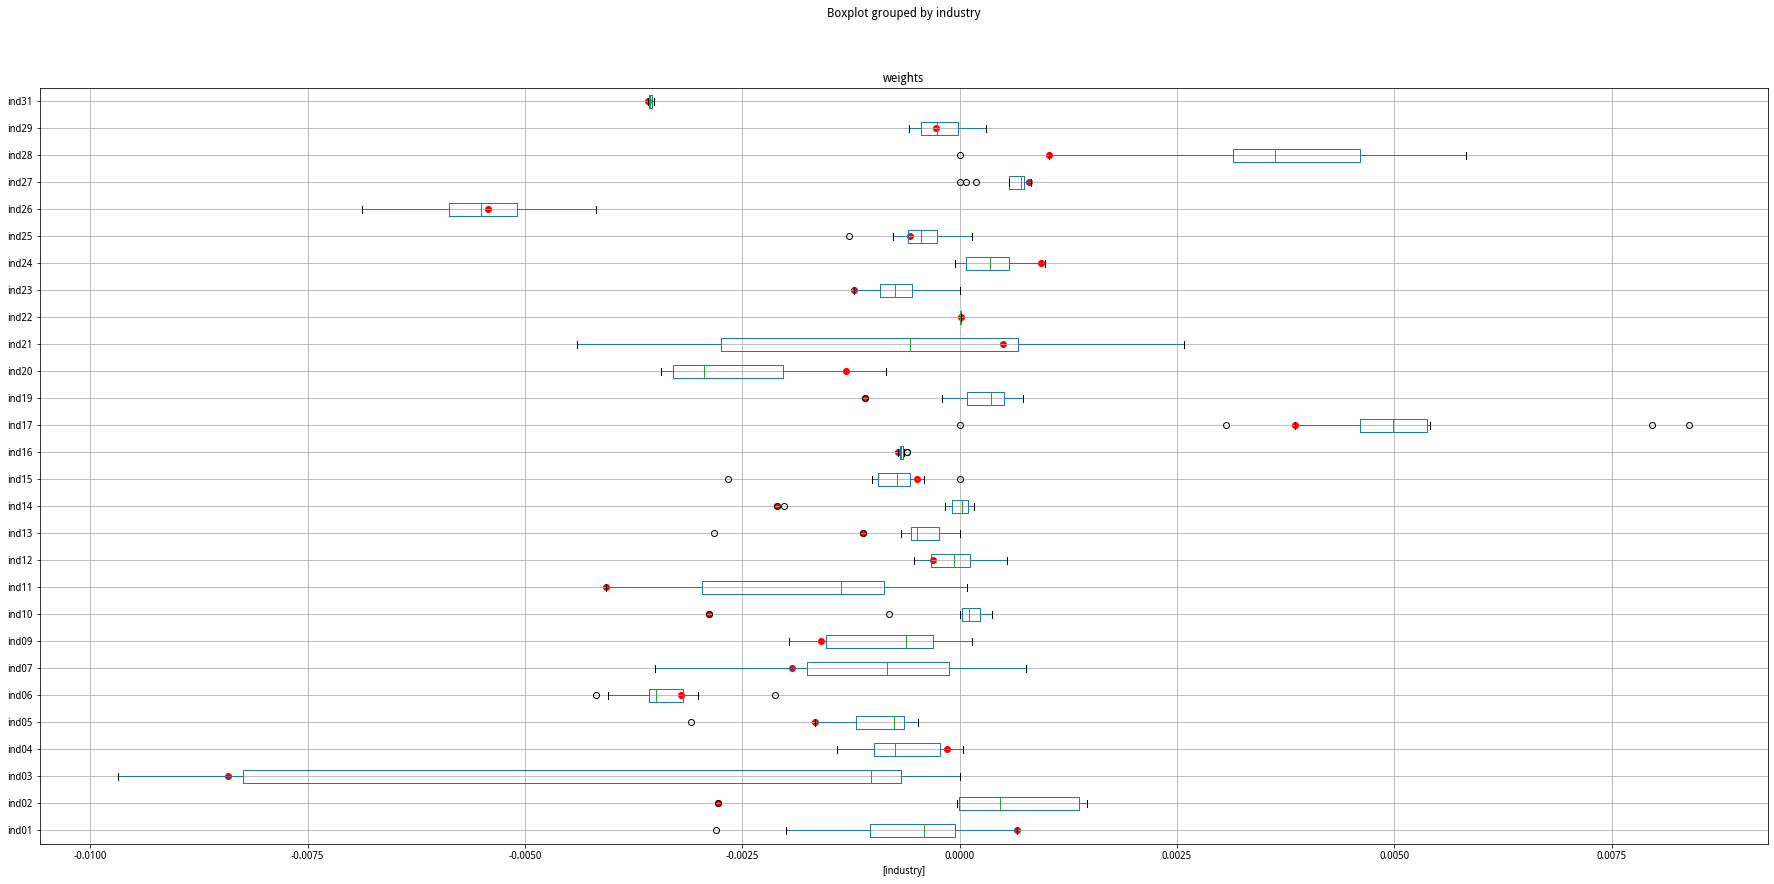

In [395]:
boxplot = final.boxplot(by='industry', vert = False, grid=True, figsize = (30,14))
y = ["placeholder"]
y+=list(recent["industry"])
x = [np.nan]
x+=list(recent["weights"])
plt.scatter(x, y, color = "red")